# Statistics on Photometric visits for Auxtel

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-04-13
- last update : 2024-04-13
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
from lsst.geom import Angle
from lsst.geom import SpherePoint
from lsst.geom import AngleUnit

from astropy.stats import SigmaClip


In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"


collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

where_clause = "instrument = \'" + instrument+ "\'"
NDET = 1

fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [95]:
def isradec_inbbox_angularsep(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    float in degree
    
    """

   
    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)
  
    RAMEAN = np.mean([RAMIN,RAMAX])
    DECMEAN = np.mean([DECMIN,DECMAX])

   
    
    sp0 = SpherePoint(longitude=geom.Angle(ra,geom.degrees),latitude=geom.Angle(dec,geom.degrees))
    sp1 = SpherePoint(longitude=geom.Angle(RAMEAN,geom.degrees),latitude=geom.Angle(DECMEAN,geom.degrees)) 
    
    sep = sp0.separation(sp1).asDegrees()
     
    return sep

In [8]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [96]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


In [97]:
def FindTractAndPatchFromAngularSep(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    Need the tractsId_list not to scan the whole skymap
    """

    print(FindTractAndPatchFromAngularSep)
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        
        # loop on tracts
        List_of_tractids = []
        List_of_patchids = []
        List_of_sep = []
        
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
         
            wcs=tractInfo.getWcs()
            # loop on patches
            patches_ids = []
            patches_sep = []
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                  
                    sep = isradec_inbbox_angularsep(ra,dec,wcs, ibb)
                    patches_ids.append(patchID)
                    patches_sep.append(sep)
                    
            # find the patch with the minimum distance
            patches_ids=np.array(patches_ids)
            patches_sep= np.array(patches_sep)
            idx_sepmin = int(np.where(patches_sep==patches_sep.min())[0])
            
            
            List_of_tractids.append(tractID)
            List_of_patchids.append(patches_ids[idx_sepmin])
            List_of_sep.append(patches_sep[idx_sepmin])
            
        List_of_tractids=np.array(List_of_tractids)
        List_of_patchids=np.array(List_of_patchids)
        List_of_sep= np.array(List_of_sep)
        idx_sepmin = int(np.where(List_of_sep==List_of_sep.min())[0])

        tractID_sel = List_of_tractids[idx_sepmin]
        patchID_sel = List_of_patchids[idx_sepmin]
       
            
        return pd.Series([tractID_sel,patchID_sel])
               
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Iteration

## Initiate the butler

In [11]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985']


In [12]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [13]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [14]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [15]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[3864, 5614, 5615, 5634]


In [16]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [17]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [18]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43453134336    20240308
43453134592    20240308
43453134848    20240308
43453135104    20240308
43453135360    20240308
Name: nightObs, Length: 3993, dtype: int64

In [19]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [20]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    columns_selected = ["ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_tract_patch_table.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985.csv found !!! ==> Read it !!!


In [21]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.697306,7.760594,11.193549,7.856800,0.025776,0.014186,27,-0.002812,-0.001684,0.028204,0.007311,0.066781,0.043159,0.005508,0.449597,1922.977051,0.213347,0.016604,2.680115,0.159810,-24.053747,0,1.749004,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874,0,0,20230511,5615,295
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.838850,6.321881,28.073927,8.586373,0.026761,0.017073,36,0.004348,-0.017695,0.039457,0.038433,0.016566,0.088571,0.013995,0.303527,1387.484985,0.166373,0.025021,1.068607,0.207413,-24.036848,0,1.424821,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,512,2,20230511,5615,295
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.716721,8.038972,10.700970,7.854424,0.024561,0.014016,15,0.000819,-0.009080,0.013239,0.003397,0.129652,0.081767,0.009968,0.387803,2265.302246,0.215552,0.015474,2.803484,0.165628,-24.045512,0,1.811649,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,1536,6,20230511,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.858833,6.754847,23.952974,8.440454,0.023946,0.012757,24,-0.006401,0.005997,0.036388,0.022835,-0.003559,0.056631,0.008252,1.230267,2129.429688,0.177205,0.021916,1.252454,0.215191,-24.046364,0,1.522426,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,2048,8,20230511,5615,294
40919699200,2023051100271,SDSSi_65mm~empty,i,239.977384,-24.051453,53.394787,27.826286,6.488425,23.321407,8.416399,0.028203,0.012467,29,-0.001410,0.001387,0.026839,0.013898,0.008566,0.101609,0.015674,0.389506,1594.576904,0.185779,0.023753,1.286372,0.202669,-24.051453,0,1.462219,324.227336,2023-05-12 01:24:47.058502,60076.058878,30.0,2023-05-12 01:24:32.058502,60076.058704,30.2432,4071,3999,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845,2304,9,20230511,5615,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,2024030800566,empty~SDSSy_65mm,y,122.493129,-36.203685,52.129131,26.166447,4.858362,13.559249,8.029708,0.016093,0.008375,56,0.003102,0.002562,0.026002,0.028631,0.004972,0.062312,0.012685,0.680248,1446.534058,0.026788,0.042366,2.212512,0.009526,-36.203685,0,1.094969,359.995886,2024-03-09 05:56:19.403505,60378.247447,30.0,2024-03-09 05:56:04.403505,60378.247273,30.2347,4071,3999,122.426835,-36.257489,122.561095,-36.256166,122.559331,-36.149845,122.425254,-36.151166,2533437440,979700304,20240308,3864,236
43453134592,2024030800567,SDSSg_65mm~empty,g,122.510609,-36.203581,52.449371,27.953827,6.89

In [22]:
ccd_visit_table_patchnotfound =  ccd_visit_table[ccd_visit_table.patchID==0]

In [23]:
ccd_visit_table_patchnotfound

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41381091072,2023070500343,SDSSr_65mm~empty,r,270.213074,-25.024755,8.10134,27.747074,7.988668,36.660618,9.167759,0.018369,0.013279,41,0.001384,-0.007442,0.011159,0.013866,0.065697,0.065391,0.008023,0.344252,1508.036987,0.067377,0.015669,0.818317,0.175153,-25.024755,0,1.800194,0.000091,2023-07-06 04:17:43.339491,60131.178974,30.0,2023-07-06 04:17:28.339491,60131.1788,30.2355,4071,3999,270.154108,-25.078619,270.273588,-25.0772,270.271989,-24.970868,270.152613,-24.972286,461394176,19400081,20230705,0,0


In [24]:
ccd_visit_table_patchnotfound.drop(columns=["tractID","patchID"],inplace=True)

/tmp/ipykernel_5329/2823564938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_patchnotfound.drop(columns=["tractID","patchID"],inplace=True)


In [26]:
row

visitId                                       2023070500343
physical_filter                            SDSSr_65mm~empty
band                                                      r
ra                                               270.213074
dec                                              -25.024755
zenithDistance                                      8.10134
zeroPoint                                         27.747074
psfSigma                                           7.988668
skyBg                                             36.660618
skyNoise                                           9.167759
astromOffsetMean                                   0.018369
astromOffsetStd                                    0.013279
nPsfStar                                                 41
psfStarDeltaE1Median                               0.001384
psfStarDeltaE2Median                              -0.007442
psfStarDeltaE1Scatter                              0.011159
psfStarDeltaE2Scatter                   

In [98]:
FindTractAndPatchFromAngularSep(row)

<function FindTractAndPatchFromAngularSep at 0x7fe8be3a9440>


0    5634
1      72
dtype: int64

In [99]:
ccd_visit_table_patchnotfound[["tractID","patchID"]] = ccd_visit_table_patchnotfound.apply(FindTractAndPatchFromAngularSep, axis=1,result_type ='expand')

<function FindTractAndPatchFromAngularSep at 0x7fe8be3a9440>


/tmp/ipykernel_5329/2902263191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_patchnotfound[["tractID","patchID"]] = ccd_visit_table_patchnotfound.apply(FindTractAndPatchFromAngularSep, axis=1,result_type ='expand')


In [100]:
ccd_visit_table_patchnotfound

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41381091072,2023070500343,SDSSr_65mm~empty,r,270.213074,-25.024755,8.10134,27.747074,7.988668,36.660618,9.167759,0.018369,0.013279,41,0.001384,-0.007442,0.011159,0.013866,0.065697,0.065391,0.008023,0.344252,1508.036987,0.067377,0.015669,0.818317,0.175153,-25.024755,0,1.800194,0.000091,2023-07-06 04:17:43.339491,60131.178974,30.0,2023-07-06 04:17:28.339491,60131.1788,30.2355,4071,3999,270.154108,-25.078619,270.273588,-25.0772,270.271989,-24.970868,270.152613,-24.972286,461394176,19400081,20230705,5634,72


## Statistic per detector and per band

In [30]:
ser_ccdvisit_perdetectorband_size = ccd_visit_table.groupby(["detector","band"]).size()

In [31]:
ser_ccdvisit_perdetectorband_size

detector  band
0         g       1045
          i        506
          r       1215
          y        583
          z        644
dtype: int64

In [32]:
df_ccdvisit_perdetectorband = ser_ccdvisit_perdetectorband_size.unstack(level=1)
df_ccdvisit_perdetectorband 

band,g,i,r,y,z
detector,,,,,
0,1045,506,1215,583,644


In [33]:
#my_colors = list(islice(cycle(['g', 'r', 'orange','grey',"k"]), None, len(df_ccdvisit_perdetectorband)))
my_colors = list(islice(cycle(['g', 'r', 'orange','grey',"k"]), None, NDET))

<Axes: title={'center': 'Number of ccdvisits per detector and per filter'}, xlabel='detector'>

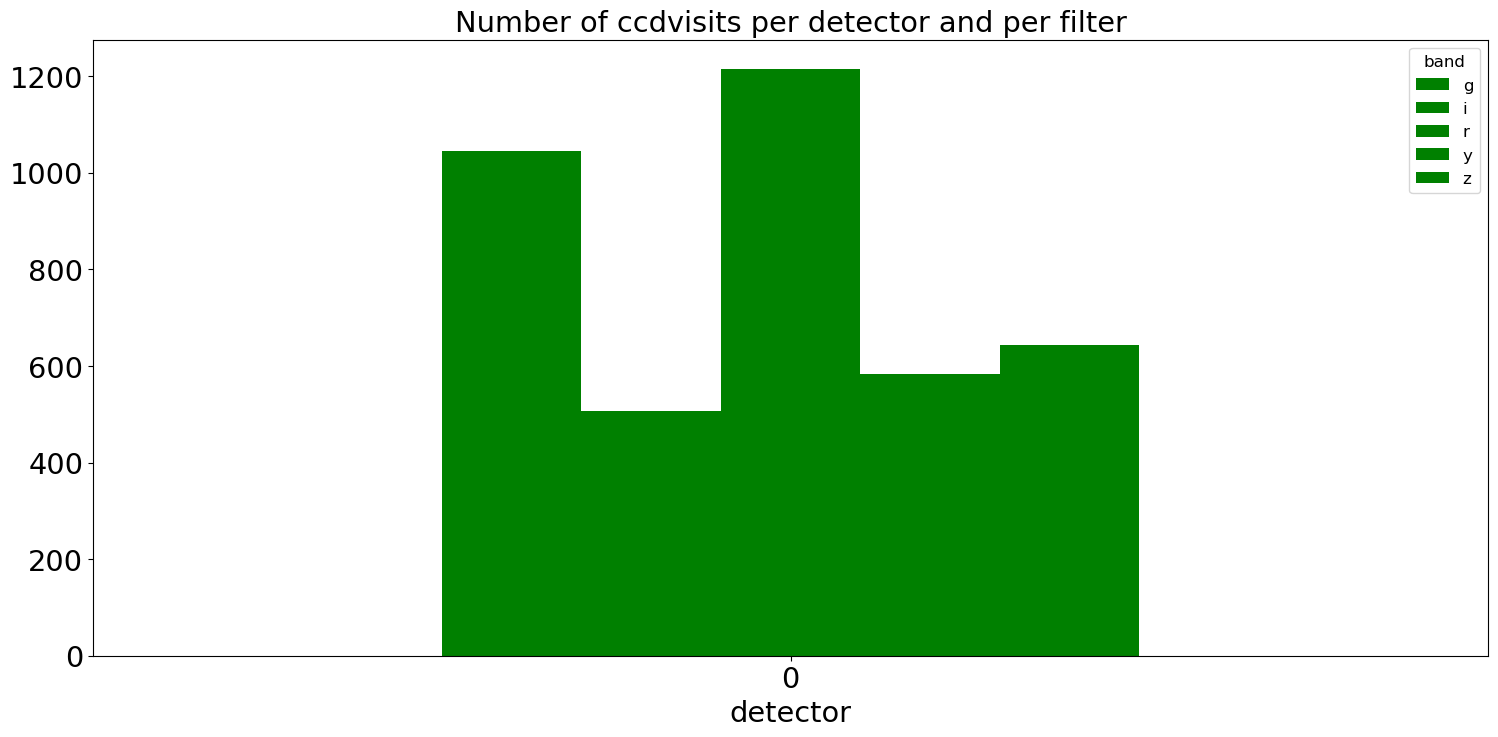

In [34]:
df_ccdvisit_perdetectorband.plot.bar(color=my_colors,rot=0,title="Number of ccdvisits per detector and per filter") 

In [35]:
cmap = ListedColormap(sns.color_palette("hls", NDET))
all_det_colors = [cmap.colors[idx] for idx in range(NDET)]

In [36]:
df_ccdvisit_perdetectorband = ser_ccdvisit_perdetectorband_size.unstack(level=0)
df_ccdvisit_perdetectorband 

detector,0
band,
g,1045
i,506
r,1215
y,583
z,644


<Axes: title={'center': 'Number of CCDvisits per detector and per filter'}, xlabel='band'>

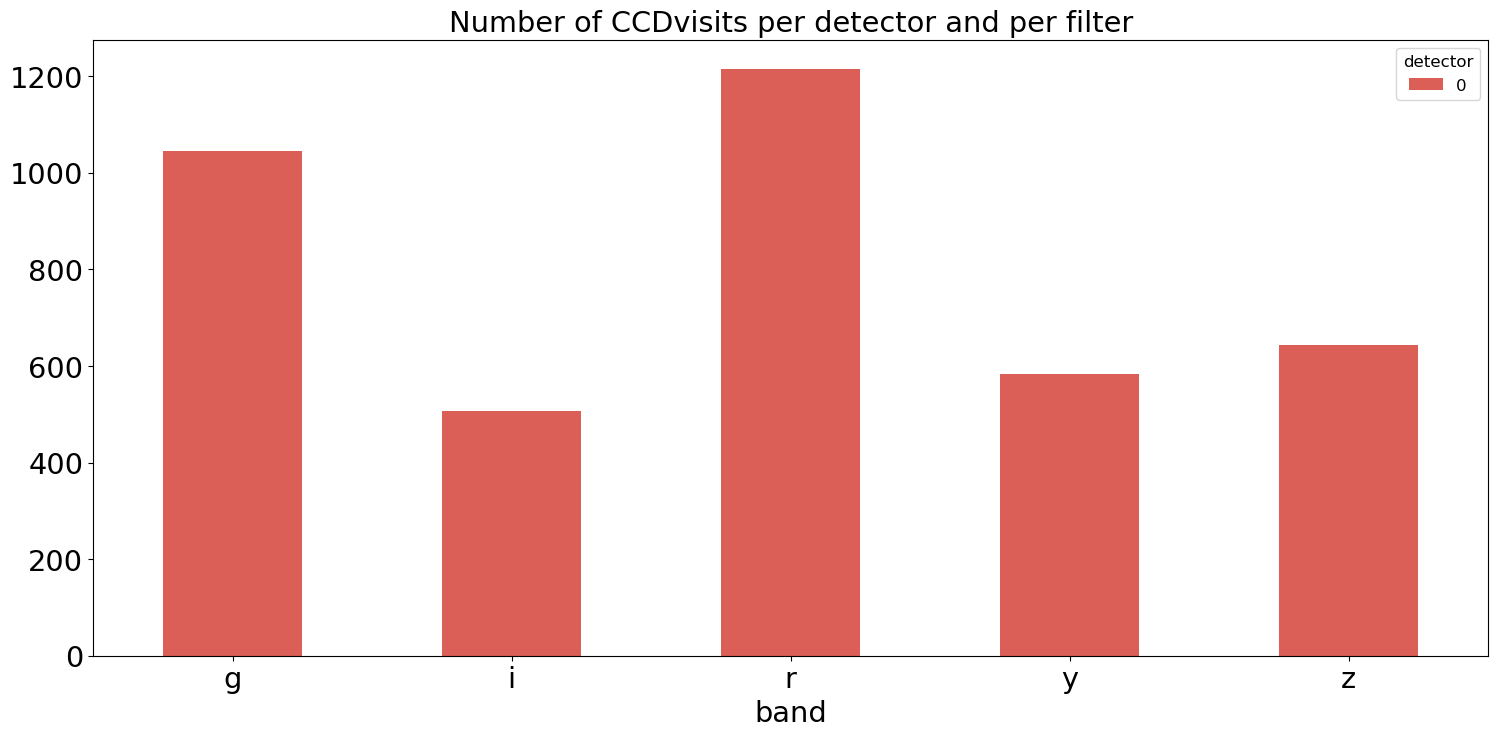

In [37]:
df_ccdvisit_perdetectorband.plot.bar(color=all_det_colors + all_det_colors + all_det_colors,rot=0,title="Number of CCDvisits per detector and per filter") 

<Axes: title={'center': 'Number of ccdvisits per detector and per filter'}, xlabel='detector,band'>

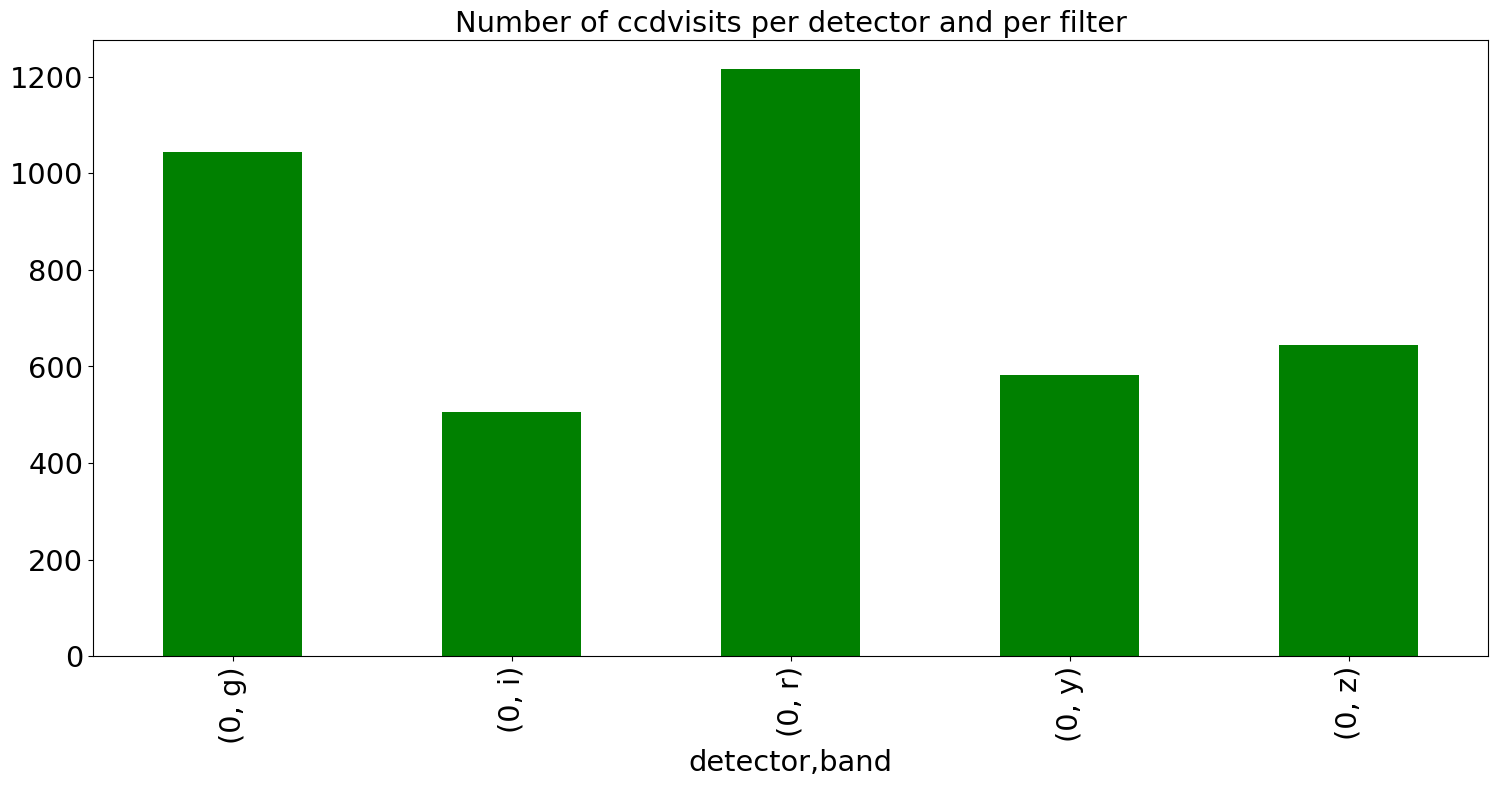

In [38]:
my_colors = list(islice(cycle(['g', 'r', 'orange']), None, NDET))
ser_ccdvisit_perdetectorband_size.plot.bar(x="detector",color=my_colors,title="Number of ccdvisits per detector and per filter")

## Visits

In [39]:
ser_tract_det_size = ccd_visit_table[["Vid","ccdVid","detector","tractID","patchID"]].groupby(["tractID","detector"]).size()

In [40]:
ser_tract_det_size

tractID  detector
0        0              1
3864     0           2521
5614     0            116
5615     0            498
5634     0            857
dtype: int64

In [41]:
df_ccdvisit_pertractdet = ser_tract_det_size.unstack(level=1)

In [42]:
df_ccdvisit_pertractdet

detector,0
tractID,
0,1
3864,2521
5614,116
5615,498
5634,857


<Axes: title={'center': 'Number of ccdvisits per patch per detector'}, xlabel='tractID'>

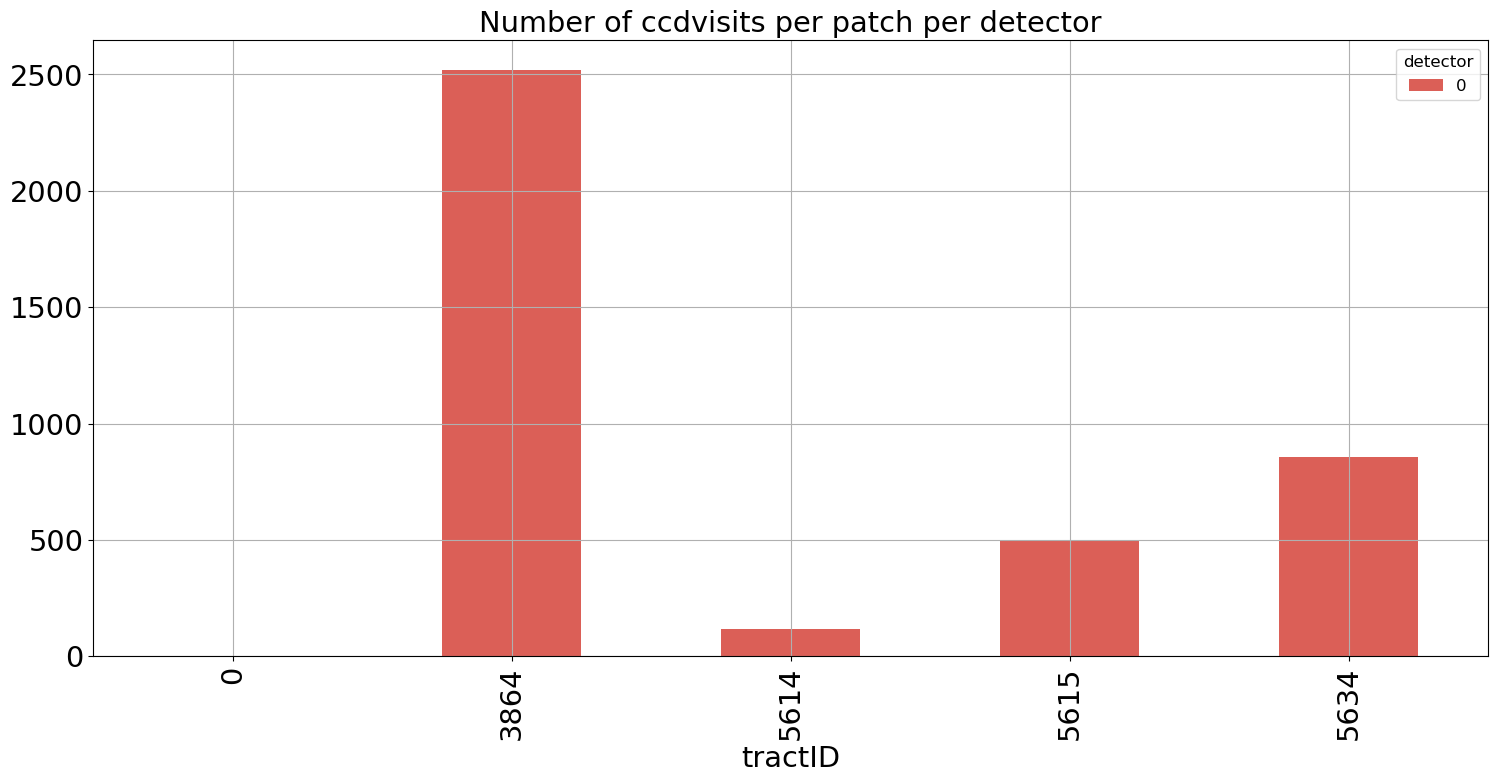

In [43]:
df_ccdvisit_pertractdet.plot.bar(color=all_det_colors,title="Number of ccdvisits per patch per detector",grid=True) 

## Understanding Vid and tractId

In [44]:
List_OfTracts = df_ccdvisit_pertractdet.index
NTracts = len(List_OfTracts)-1
NTracts

4

In [45]:
cmap = ListedColormap(sns.color_palette("hls", NTracts))
list_tracts_colors = [cmap.colors[idx] for idx in range(NTracts)]

In [46]:
list_tracts_colors = [ colors.to_rgb('k') ] + list_tracts_colors

In [47]:
len(list_tracts_colors)

5

In [48]:
dict_tract_colors = {}
for idx,itr in enumerate(List_OfTracts):
    dict_tract_colors[itr] = list_tracts_colors[idx]
    

In [49]:
all_colors = [ dict_tract_colors[itr] for itr in ccd_visit_table["tractID"].values]

<Axes: title={'center': 'tractID vs visit sequence number'}, xlabel='Vid', ylabel='tractID'>

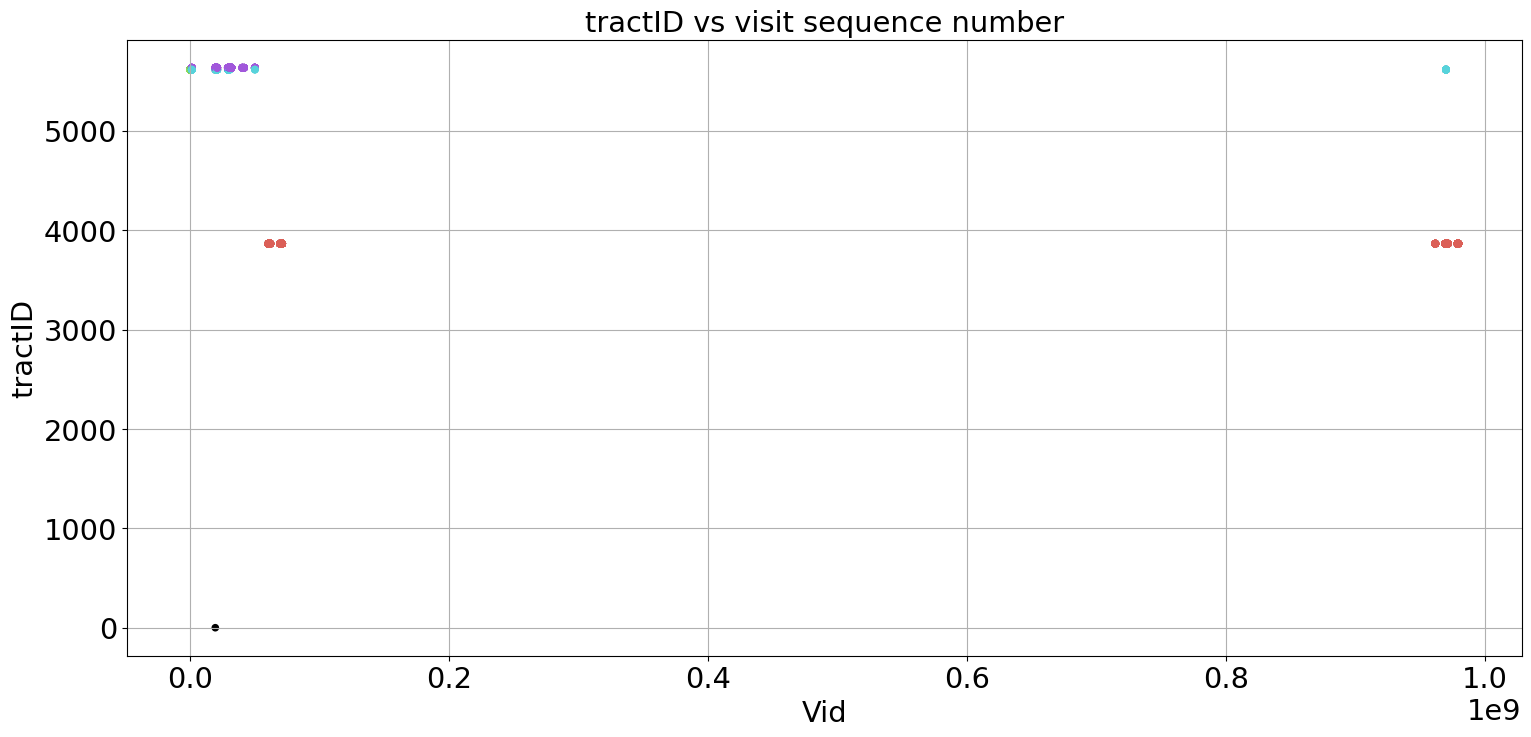

In [50]:
ccd_visit_table.plot.scatter(y="tractID",x ="Vid",marker='o',color=all_colors,title="tractID vs visit sequence number",grid=True)

In [51]:
List_OfTracts

Int64Index([0, 3864, 5614, 5615, 5634], dtype='int64', name='tractID')

## simple visit table

In [52]:
visit_table = butler.get('visitTable', dataId={'instrument': instrument}, collections = collections )    
visit_table

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100270,2023051100270,SDSSi_65mm~empty,i,239.963850,-24.048746,-24.048746,170.004124,99.285576,35.972240,54.027760,1.697680,30.0,2023-05-12 01:22:36.150002,60076.057363,2023-05-12 01:22:21.150002,60076.057189
2023051100271,2023051100271,SDSSi_65mm~empty,i,239.973090,-24.048045,-24.048045,324.227336,99.067939,36.430601,53.569399,1.679779,30.0,2023-05-12 01:24:47.058502,60076.058878,2023-05-12 01:24:32.058502,60076.058704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024030800566,2024030800566,empty~SDSSy_65mm,y,122.492619,-36.204838,-36.204838,359.995886,245.577961,38.065290,51.934710,1.617120,30.0,2024-03-09 05:56:19.403505,60378.247447,2024-03-09 05:56:04.403505,60378.247273
2024030800567,2024030800567,SDSSg_65mm~empty,g,122.510969,-36.204831,-36.204831,359.995708,245.486067,37.744824,52.255176,1.628651,30.0,2024-03-09 05:58:01.104001,60378.248624,2024-03-09 05:57:46.104001,60378.248450
2024030800568,2024030800568,SDSSr_65mm~empty,r,122.510924,-36.204839,-36.204839,359.995620,245.441490,37.590552,52.409448,1.634279,30.0,2024-03-09 05:58:47.775498,60378.249164,2024-03-09 05:58:32.775498,60378.248990


## Find Tracts involved for each date

In [53]:
df = ccd_visit_table

In [54]:
df_stat_pertract = df.groupby(by=["nightObs","tractID"]).count()["visitId"]
df_stat_pertract

nightObs  tractID
20230511  5614       116
          5615       153
20230523  5615        20
          5634        10
20230524  5615        34
                    ... 
20240304  3864       100
20240305  3864        96
20240306  3864        61
20240307  3864        90
20240308  3864        96
Name: visitId, Length: 68, dtype: int64

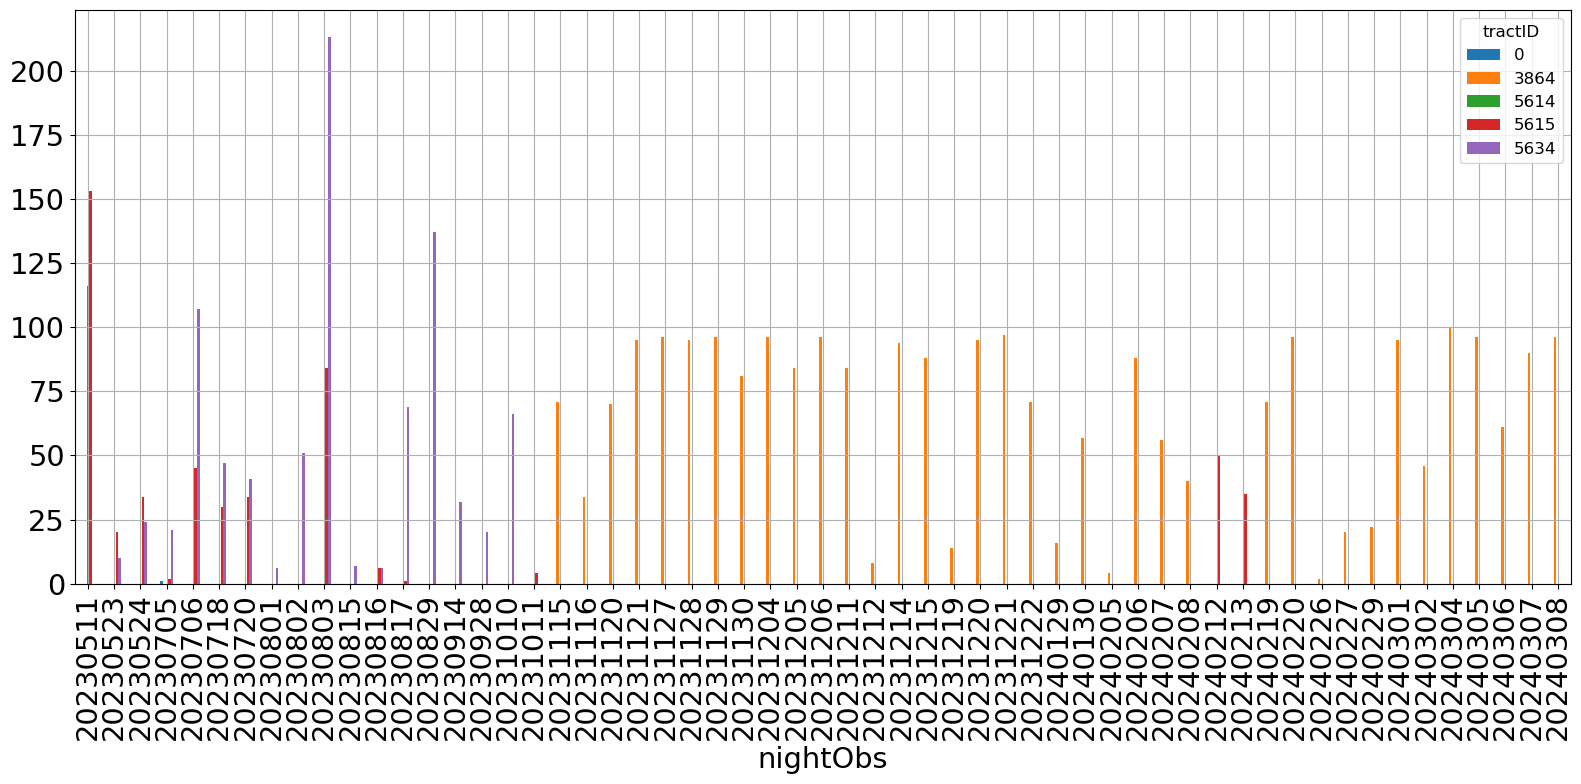

In [55]:
ax = df_stat_pertract.unstack(level=1).plot(kind='bar', subplots=False, rot=90,figsize=(16,8),grid=True)
plt.tight_layout()

/tmp/ipykernel_5329/1560612957.py:2: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


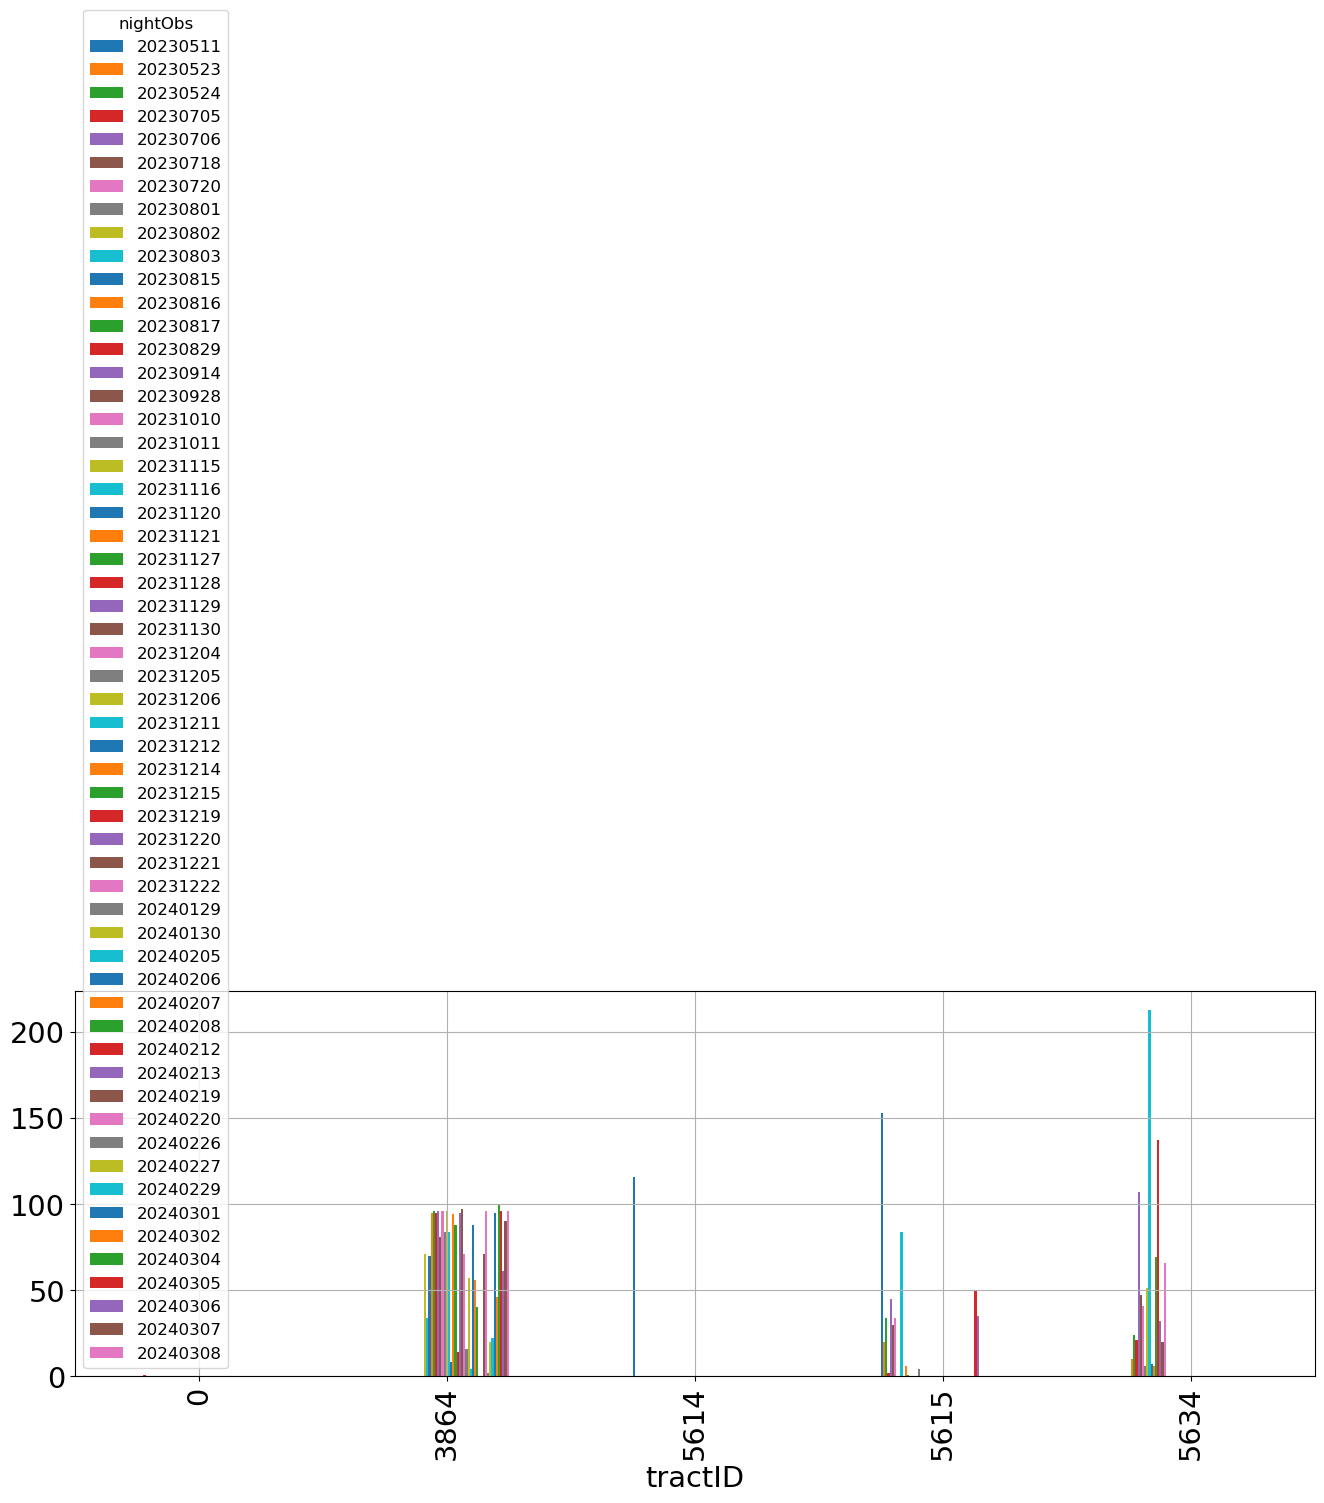

In [56]:
ax = df_stat_pertract.unstack(level=0).plot(kind='bar', subplots=False, rot=90,figsize=(16,5),grid=True)
plt.tight_layout()

## Pandas series

In [57]:
ccd_visit_table_counts = df.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_g = df[df["band"] == "g"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_r = df[df["band"] == "r"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_i = df[df["band"] == "i"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_z = df[df["band"] == "z"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_y = df[df["band"] == "y"].groupby(['nightObs']).count()["visitId"]

In [58]:
print(ccd_visit_table_counts)

nightObs  band
20230511  g       86
          i       92
          r       91
20230523  g       11
          i       11
                  ..
20240307  z       24
20240308  g       24
          r       24
          y       24
          z       24
Name: visitId, Length: 198, dtype: int64


### Observation date-time

In [59]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [60]:
[convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index ]

[Timestamp('2023-05-11 00:00:00'),
 Timestamp('2023-05-23 00:00:00'),
 Timestamp('2023-05-24 00:00:00'),
 Timestamp('2023-07-05 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-18 00:00:00'),
 Timestamp('2023-07-20 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-08-02 00:00:00'),
 Timestamp('2023-08-03 00:00:00'),
 Timestamp('2023-08-16 00:00:00'),
 Timestamp('2023-08-17 00:00:00'),
 Timestamp('2023-08-29 00:00:00'),
 Timestamp('2023-09-28 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-11 00:00:00'),
 Timestamp('2023-11-15 00:00:00'),
 Timestamp('2023-11-16 00:00:00'),
 Timestamp('2023-11-20 00:00:00'),
 Timestamp('2023-11-21 00:00:00'),
 Timestamp('2023-11-27 00:00:00'),
 Timestamp('2023-11-28 00:00:00'),
 Timestamp('2023-11-29 00:00:00'),
 Timestamp('2023-11-30 00:00:00'),
 Timestamp('2023-12-04 00:00:00'),
 Timestamp('2023-12-05 00:00:00'),
 Timestamp('2023-12-06 00:00:00'),
 Timestamp('2023-12-11 00:00:00'),
 Timestamp('2023-12-

In [61]:
dt_g = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index])
dt_r = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_r.index ])
dt_i = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_i.index ])
dt_z = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_z.index ])
dt_y = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_y.index ])

### observation counts

In [62]:
n_g = ccd_visit_table_counts_g.values
n_r = ccd_visit_table_counts_r.values
n_i = ccd_visit_table_counts_i.values
n_z = ccd_visit_table_counts_z.values
n_y = ccd_visit_table_counts_y.values

In [63]:
n_g_tot = np.sum(n_g)
n_r_tot = np.sum(n_r)
n_i_tot = np.sum(n_i)
n_z_tot = np.sum(n_z)
n_y_tot = np.sum(n_y)

n_g_min = np.min(n_g)
n_r_min = np.min(n_r)
n_i_min = np.min(n_i)
#n_z_min = np.min(n_z)
#n_y_min = np.min(n_y)

n_g_max = np.max(n_g)
n_r_max = np.max(n_r)
n_i_max = np.max(n_i)
#n_z_max = np.max(n_z)
#n_y_max = np.max(n_y)

### Observation count sum

In [64]:
s_g = n_g.cumsum()
s_r = n_r.cumsum()
s_i = n_i.cumsum()
s_z = n_z.cumsum()
s_y = n_y.cumsum()

## Plot

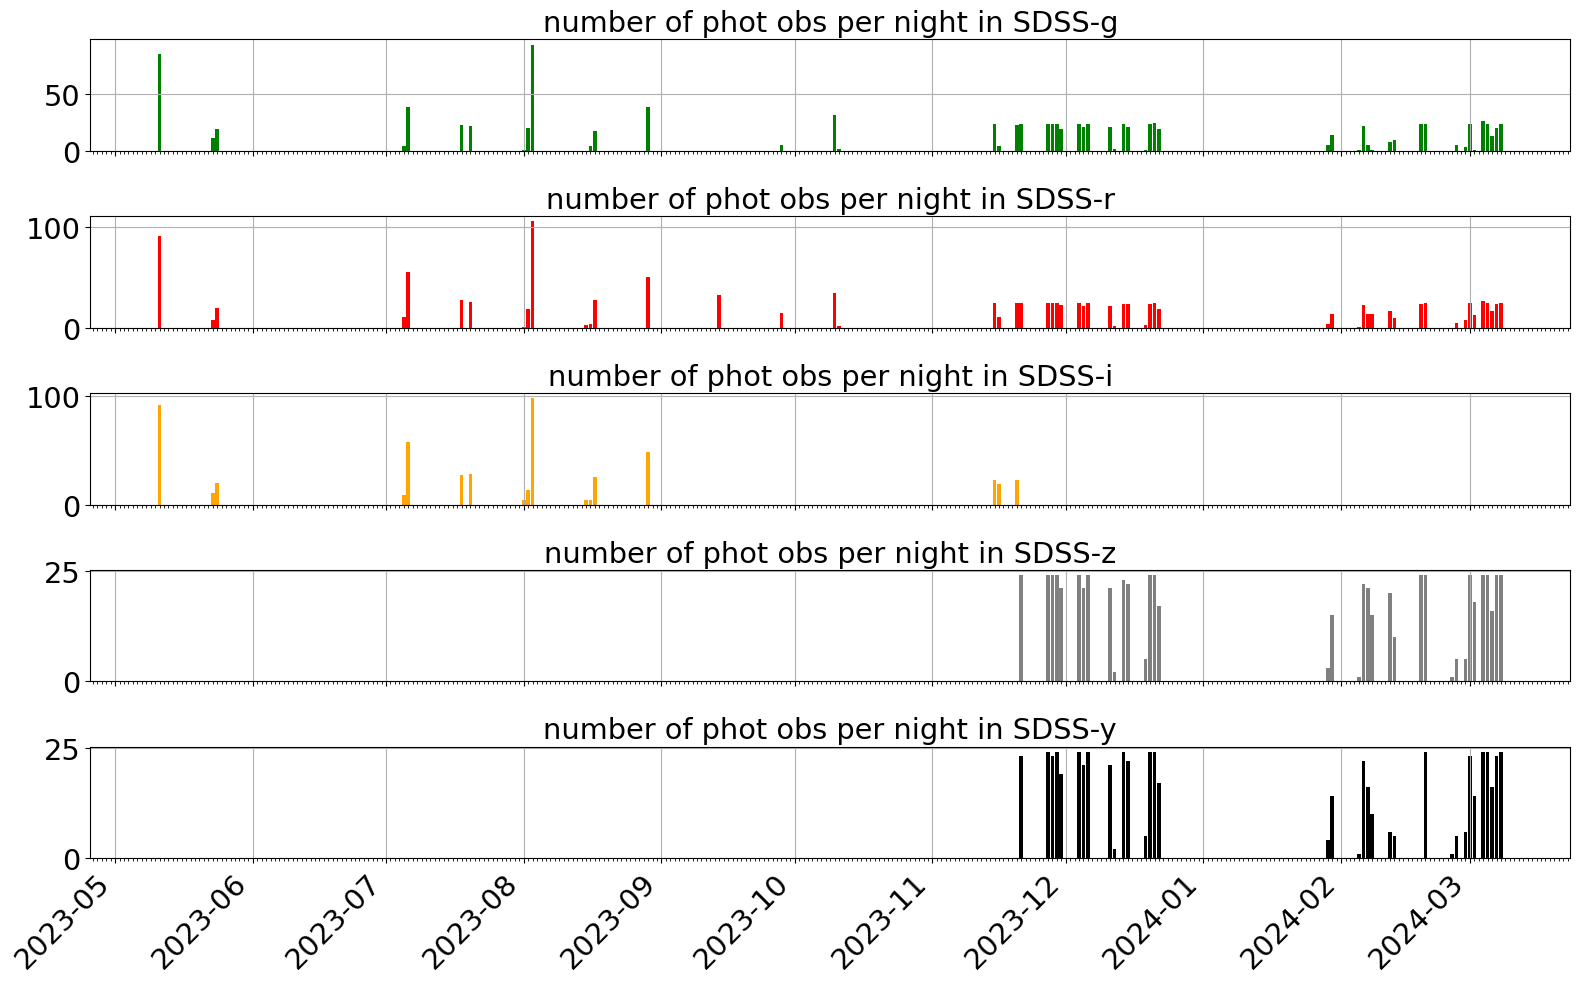

In [65]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(5,1,figsize=(16, 10),sharex=True)

ax1,ax2,ax3,ax4,ax5 = axs

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g,n_g,lw=5,facecolor='g')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

title1 = f"number of phot obs per night in SDSS-g"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.bar(dt_r,n_r,lw=5,facecolor='r')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"number of phot obs per night in SDSS-r"
ax2.set_title(title2)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax3.bar(dt_i,n_i,lw=5,facecolor='orange')
ax3.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax3.xaxis.set_minor_locator(day_locator)
ax3.xaxis.set_major_formatter(year_month_formatter)
ax3.grid()

#fig.autofmt_xdate() # rotation
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right')
title3 = f"number of phot obs per night in SDSS-i"
ax3.set_title(title3)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax4.bar(dt_z,n_z,lw=5,facecolor='grey')
ax4.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax4.xaxis.set_minor_locator(day_locator)
ax4.xaxis.set_major_formatter(year_month_formatter)
ax4.grid()

#fig.autofmt_xdate() # rotation
ax4.set_xticks(ax4.get_xticks(), ax4.get_xticklabels(), rotation=45, ha='right')
title4 = f"number of phot obs per night in SDSS-z"
ax4.set_title(title4)


#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax5.bar(dt_y,n_y,lw=5,facecolor='k')
ax5.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax5.xaxis.set_minor_locator(day_locator)
ax5.xaxis.set_major_formatter(year_month_formatter)
ax5.grid()

#fig.autofmt_xdate() # rotation
ax5.set_xticks(ax5.get_xticks(), ax5.get_xticklabels(), rotation=45, ha='right')
title5 = f"number of phot obs per night in SDSS-y"
ax5.set_title(title5)


plt.tight_layout()

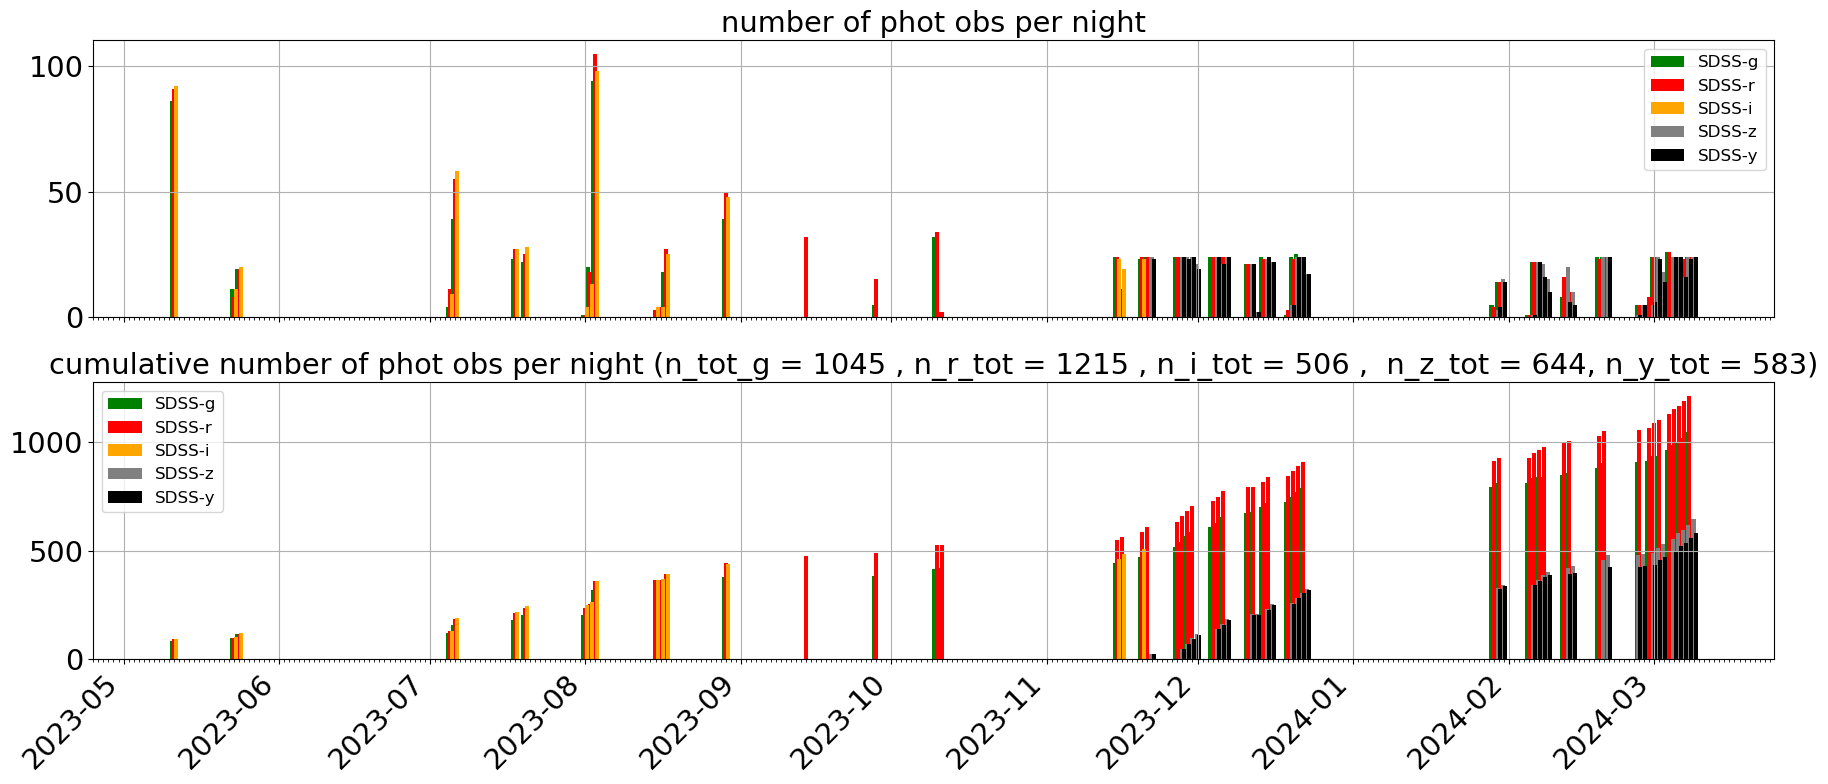

In [66]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(2,1,figsize=(18, 8),sharex=True)

ax1,ax2 = axs

dt = timedelta(hours=10)

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g-dt,n_g,lw=5,facecolor='g',label="SDSS-g")
ax1.bar(dt_r,n_r,lw=5,facecolor='r',label="SDSS-r")
ax1.bar(dt_i+dt,n_i,lw=5,facecolor='orange',label="SDSS-i")
ax1.bar(dt_z+2*dt,n_z,lw=5,facecolor='grey',label="SDSS-z")
ax1.bar(dt_y+3*dt,n_y,lw=5,facecolor='k',label="SDSS-y")
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax1.legend()
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

title = f"number of phot obs per night"
ax1.set_title(title)


ax2.bar(dt_g-dt,s_g,lw=5,facecolor='g',label="SDSS-g")
ax2.bar(dt_r,s_r,lw=5,facecolor='r',label="SDSS-r")
ax2.bar(dt_i+dt,s_i,lw=5,facecolor='orange',label="SDSS-i")
ax2.bar(dt_z+2*dt,s_z,lw=5,facecolor='grey',label="SDSS-z")
ax2.bar(dt_y+3*dt,s_y,lw=5,facecolor='k',label="SDSS-y")
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()
ax2.legend()
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')

title = f"cumulative number of phot obs per night (n_tot_g = {n_g_tot} , n_r_tot = {n_r_tot} , n_i_tot = {n_i_tot} ,  n_z_tot = {n_z_tot}, n_y_tot = {n_y_tot})"
ax2.set_title(title)


plt.tight_layout()